# Important Variable

In [43]:
#!jupyter nbconvert --to script model_build.ipynb

import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy.signal import resample

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, linregress
import random
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.python.client import device_lib
import matplotlib.colors as mcolors

[NbConvertApp] Converting notebook model_build.ipynb to script
[NbConvertApp] Writing 42883 bytes to model_build.py


In [2]:
print(tf.__version__)

2.16.2


In [3]:
tf.config.experimental.list_physical_devices('GPU')
device_lib.list_local_devices()

2024-07-04 15:22:28.786069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 47136 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-07-04 15:22:28.787618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:1 with 47136 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-07-04 15:22:28.789032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:2 with 47136 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-07-04 15:22:28.790132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:3 with 47136 MB memory:  -> device: 3, name: Quadro RTX 8000, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-07-04 15:22:28.791222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /dev

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17287305859857038659
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 49426071552
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 2
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 3
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 4
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 5
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 6
       type: "StreamExecutor"
       strength: 1
     }
     link {
       device_id: 7
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 17495133953856849056
 physical_device_desc: "device: 0, name: Quadro RTX 8000, pci bus id: 0000:1b:00.0, compute capab

In [4]:
MODEL_NAME = '3_inputs_model'
RUN = 'run6_' + MODEL_NAME+ '/'

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/dataset/'
MASTER_OUTPUT_DIR = CURRENT_DIR + '/output/'
OUTPUT_DIR = MASTER_OUTPUT_DIR + RUN
print(DATA_DIR)
print(OUTPUT_DIR)

/nfs/ada/jbrook1/users/qdang1/Fantasia_respiration/dataset/
/nfs/ada/jbrook1/users/qdang1/Fantasia_respiration/output/run6_3_inputs_model/


In [5]:
#data_df[data_df['subject_id'] != 'f2y08']['snr'].describe()

# Load data

In [6]:
data_df = pd.read_pickle(DATA_DIR + 'fantasia_dataset_preprocessing.plk')
data_df

,subject_id,chunk_id,ecg,resp,Mean_Respiration_Rate,Total_Area_Peak_to_Trough,Total_Area_Trough_to_Peak,Mean_latency_Trough_to_Peak,Mean_latency_Peak_to_Trough,hr_min,hr_mean,hr_max,hrv,snr
0,f1o01,0,"[8.46, 8.592, 8.352, 8.152, 8.34, 8.528, 8.312...","[8.488, 8.452, 8.488, 8.496, 8.508, 8.476, 8.4...",14.505123,0.562117,1.169217,1.690667,2.544000,59.055118,62.032517,66.371681,16.625697,5.385646
1,f1o01,1,"[8.316, 8.58, 8.664, 8.428, 8.264, 8.444, 8.58...","[8.116, 8.124, 8.092, 8.088, 8.06, 8.064, 8.07...",15.780254,1.146417,0.315799,1.525143,2.221333,58.593750,62.245654,66.079295,16.559194,5.984316
2,f1o01,2,"[8.088, 8.088, 8.26, 8.304, 8.144, 8.072, 8.2,...","[8.656, 8.624, 8.608, 8.596, 8.648, 8.652, 8.6...",13.284661,0.353985,0.445506,1.772000,2.860000,57.692308,59.618603,61.728395,8.315218,6.507062
3,f1o01,3,"[8.152, 8.02, 8.036, 8.208, 8.208, 8.128, 8.12...","[8.672, 8.684, 8.648, 8.632, 8.628, 8.672, 8.6...",14.913591,0.688938,1.089432,1.680000,2.391000,32.894737,62.955495,69.124424,261.545152,6.893892
4,f1o01,4,"[8.068, 8.004, 7.864, 7.9, 8.048, 7.996, 7.848...","[8.548, 8.524, 8.508, 8.528, 8.568, 8.552, 8.5...",16.444328,0.983089,0.837500,1.479200,2.752000,57.251908,62.337664,67.264574,14.326248,5.866205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9469,f2y10,232,"[-0.10009765625, -0.09765625, -0.10009765625, ...","[0.0048828125, 0.0048828125, 0.0048828125, 0.0...",14.497019,0.197665,0.101241,1.556800,2.480000,52.631579,58.396608,66.079295,66.171494,6.985175
9470,f2y10,233,"[-0.185546875, -0.1806640625, -0.18310546875, ...","[-0.126953125, -0.12939453125, -0.126953125, -...",12.471924,0.304567,0.516003,1.549600,3.345000,51.369863,58.250585,65.789474,56.823614,7.723637
9471,f2y10,234,"[-0.01708984375, -0.01220703125, -0.01953125, ...","[0.54443359375, 0.5419921875, 0.5517578125, 0....",15.151441,0.219147,0.206771,1.567200,2.387000,49.180328,56.770476,62.761506,542.688370,6.556642
9473,f2y10,236,"[0.1025390625, 0.07568359375, 0.0439453125, 0....","[-0.185546875, -0.185546875, -0.1806640625, -0...",14.860658,0.272106,0.304594,1.684667,2.696000,50.000000,56.347270,64.655172,63.884896,7.360403


# Preprocessing

In [7]:
chunks_df = data_df #allias

In [8]:
chunks_df = chunks_df.dropna(subset=['Mean_Respiration_Rate','hrv'])

## Standardization

In [9]:
# Convert 'ecg' column to a 3D numpy array
X = np.array(chunks_df['ecg'].tolist())
Y = chunks_df[['Mean_Respiration_Rate','Total_Area_Trough_to_Peak','Total_Area_Peak_to_Trough',
            'Mean_latency_Trough_to_Peak','Mean_latency_Peak_to_Trough']].values

# Normalize each ECG chunk individually and handle NaNs
X_normalized = np.zeros_like(X)
for i in range(X.shape[0]):
    mean = np.mean(X[i])
    std = np.std(X[i])
    if std == 0:  # Avoid division by zero
        print('sid == 0')
        std = 1
    X_normalized[i] = (X[i] - mean) / std

In [10]:
X_feature = np.array(chunks_df[['hr_min','hr_mean','hr_max','hrv','snr']])


# Normalize each ECG chunk individually and handle NaNs
X_feature_normalized = np.zeros_like(X_feature)
for i in range(X_feature.shape[1]):
    mean = np.mean(X_feature[:,i])
    std = np.std(X_feature[:,i])
    if std == 0:  # Avoid division by zero
        print('sid == 0')
        std = 1
    X_feature_normalized[:,i] = (X_feature[:,i] - mean) / std

In [11]:
print(X_normalized.shape)
print(X_feature_normalized.shape)
print(Y.shape)

(7840, 7500)
(7840, 5)
(7840, 5)


In [12]:
# Remove Nan value
nan_rows = np.isnan(X_normalized).any(axis=1)

# Remove rows with NaNs
X_normalized = X_normalized[~nan_rows]
X_feature_normalized = X_feature_normalized[~nan_rows]
Y = Y[~nan_rows]
cleaned_chunks_df = chunks_df[~nan_rows]

print(nan_rows.sum())
print(f"NaN in X_normalized after cleaning: {np.isnan(X_normalized).sum()}, Inf in X_normalized: {np.isinf(X_normalized).sum()}")

0
NaN in X_normalized after cleaning: 0, Inf in X_normalized: 0


In [13]:
print(X_normalized.shape)
print(X_feature_normalized.shape)
print(Y.shape)

(7840, 7500)
(7840, 5)
(7840, 5)


In [14]:
# # Calculate the 2.5th and 97.5th percentiles
# for i in range(Y.shape[1]):
#     lower_percentile = np.percentile(Y[:,i], 0.5)
#     upper_percentile = np.percentile(Y[:,i], 99.5)



#     # Verify the clipping
#     print('\n', i)
#     print(f"1th percentile: {lower_percentile}")
#     print(f"99th percentile: {upper_percentile}")
#     print(f"Before clipping: min = {Y[:,i].min()}, max = {Y[:,i].max()}")
#     # Clip the values in y_train
#     Y[:,i] = np.clip(Y[:,i], lower_percentile, upper_percentile)
#     print(f"After clipping: min = {Y[:,i].min()}, max = {Y[:,i].max()}")

#     # Continue with training the model using y_train_clipped

Spliting

In [15]:
from sklearn.model_selection import train_test_split


subjects = cleaned_chunks_df['subject_id'].unique()
train_val_subjects, test_subjects = train_test_split(subjects, test_size=0.2, random_state=96)
train_subjects, val_subjects = train_test_split(train_val_subjects, test_size=0.15, random_state=96)

# Create boolean masks for train, validation, and test subjects
train_mask = cleaned_chunks_df['subject_id'].isin(train_subjects)
val_mask = cleaned_chunks_df['subject_id'].isin(val_subjects)
test_mask = cleaned_chunks_df['subject_id'].isin(test_subjects)

# Use these masks to create the actual train, validation, and test datasets
train_data = cleaned_chunks_df[train_mask]
val_data = cleaned_chunks_df[val_mask]
test_data = cleaned_chunks_df[test_mask]

# Now you have train, validation, and test datasets based on the subjects
test_subject_id = cleaned_chunks_df[test_mask]['subject_id'].to_numpy()

In [16]:
print(train_subjects)
print(val_subjects)
print(test_subjects)

['f1o06' 'f1y09' 'f2y09' 'f2y04' 'f2o04' 'f1y03' 'f1o02' 'f2y10' 'f1o10'
 'f1o08' 'f2y08' 'f1o05' 'f1y01' 'f2y02' 'f1o09' 'f1y04' 'f2y05' 'f2y06'
 'f1y05' 'f1o07' 'f2o09' 'f2o01' 'f2o03' 'f2o02' 'f1o03' 'f2o10']
['f1y08' 'f1o04' 'f1y06' 'f2y01' 'f2o08']
['f2o07' 'f1o01' 'f1y10' 'f2o06' 'f2y03' 'f1y02' 'f1y07' 'f2y07']


In [17]:
X_normalized

array([[-0.00809941,  0.40926564, -0.34957991, ...,  0.27014396,
         0.40926564, -0.26104793],
       [ 0.26904106,  1.15557631,  1.43765571, ..., -0.33541479,
         0.17501459,  0.17501459],
       [-0.7231427 , -0.7231427 , -0.09334483, ..., -0.98677902,
        -0.64991039, -0.07869837],
       ...,
       [-0.02289313,  0.00324655, -0.03596296, ...,  2.7609822 ,
         1.85916343,  0.65673841],
       [ 0.90269696,  0.74909981,  0.56757591, ..., -0.27022672,
        -0.34004361, -0.34004361],
       [-0.79813056, -0.73697144, -0.67581233, ..., -0.46175542,
        -0.37001674, -0.33943718]])

In [18]:
# Apply the masks to create train, validation, and test sets
X_train = np.expand_dims(X_normalized[train_mask], 2)
Y_train = Y[train_mask] 
X_val = np.expand_dims(X_normalized[val_mask], 2)
Y_val = Y[val_mask]
X_test = np.expand_dims(X_normalized[test_mask], 2)
Y_test = Y[test_mask]

# Print shapes of the datasets to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {Y_train.shape}")
print(f"y_val shape: {Y_val.shape}")
print(f"y_test shape: {Y_test.shape}")
print(f"test_subject_id shape: {test_subject_id.shape}")

X_train shape: (5229, 7500, 1)
X_val shape: (939, 7500, 1)
X_test shape: (1672, 7500, 1)
y_train shape: (5229, 5)
y_val shape: (939, 5)
y_test shape: (1672, 5)
test_subject_id shape: (1672,)


In [19]:
# Apply the masks to create train, validation, and test sets
X_train_feature = X_feature_normalized[train_mask]
X_val_feature = X_feature_normalized[val_mask]
X_test_feature = X_feature_normalized[test_mask]


# Print shapes of the datasets to verify
print(f"X_train_feature shape: {X_train_feature.shape}")
print(f"X_val_feature shape: {X_val_feature.shape}")
print(f"X_test_feature shape: {X_test_feature.shape}")


X_train_feature shape: (5229, 5)
X_val_feature shape: (939, 5)
X_test_feature shape: (1672, 5)


In [20]:
def compute_freq_domain(X, SAMPLE_RATE = 250, N_SAMPLES = 30*250):
    X_freq = []
    for i in range(X.shape[0]):
        data = X_train[i]
        frequency_domain = np.fft.fft(data)
        #frequencies = np.fft.fftfreq(N_SAMPLES, 1/SAMPLE_RATE)
        X_freq.append(np.abs(frequency_domain))
    X_freq = np.array(X_freq)
    return X_freq
    

In [21]:
X_train_freq = compute_freq_domain(X_train)
X_val_freq =  compute_freq_domain(X_val)
X_test_freq = compute_freq_domain(X_test)

print(f"X_train_freq shape: {X_train_freq.shape}")
print(f"X_val_freq shape: {X_val_freq.shape}")
print(f"X_test_freq shape: {X_test_freq.shape}")

X_train_freq shape: (5229, 7500, 1)
X_val_freq shape: (939, 7500, 1)
X_test_freq shape: (1672, 7500, 1)


In [22]:
import pywt

def extract_wavelet_features(X, wavelet='db4', level=4):
    n_samples = X.shape[0]
    
    #calculate n_feature
    n_features = 0
    temp = pywt.wavedec(np.zeros(X.shape[1]), wavelet, level=level)
    for i in temp:
        n_features += len(i)

    X_features = np.zeros((n_samples, n_features))
    for i in range(n_samples):
        current_signal = X[i, :, 0]
        
        coeffs = pywt.wavedec(current_signal, wavelet, level=level)
        features = np.concatenate(coeffs)
        
        X_features[i, :] = features
    return X_features

In [23]:
X_train_wavelet = extract_wavelet_features(X_train, wavelet='db4', level=4)
X_val_wavelet =  extract_wavelet_features(X_val, wavelet='db4', level=4)
X_test_wavelet = extract_wavelet_features(X_test, wavelet='db4', level=4)

print(f"X_train_wavelet shape: {X_train_wavelet.shape}")
print(f"X_val_wavelet shape: {X_val_wavelet.shape}")
print(f"X_test_wavelet shape: {X_test_wavelet.shape}")

X_train_wavelet shape: (5229, 7526)
X_val_wavelet shape: (939, 7526)
X_test_wavelet shape: (1672, 7526)


In [24]:
output_ranges = np.max(Y_train, axis=0) - np.min(Y_train, axis=0)

# Calculate the inverse of the range to use as scaling factors
scaling_factors = 1 / output_ranges

# Normalize scaling factors to sum up to 1
scaling_factors /= scaling_factors.sum()

print(scaling_factors) 

[0.05508075 0.16660947 0.13356226 0.38231479 0.26243273]


# Build Model

In [25]:
EPOCHS = 200
BATCH_SIZE = 64
PATIENCE = 20

In [26]:
cleaned_chunks_df[test_mask]['subject_id'].to_numpy()

array(['f1o01', 'f1o01', 'f1o01', ..., 'f2y07', 'f2y07', 'f2y07'],
      dtype=object)

In [27]:
#create model
def create_CNN_model_5_output(shape, start_neuron = 64, kernel_size=9, strides_size=1, max_pool_size=3, dropout=0.3, padding='valid', delta=1.0):    

    input_layer = tf.keras.Input((shape[1], shape[2])) 

    
    conv_1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    conv_1 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_1)
    conv_1 = tf.keras.layers.Dropout(dropout)(conv_1)
    
    conv_2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size, strides=strides_size, padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_1)
    conv_2 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_2)
    conv_2 = tf.keras.layers.Dropout(dropout)(conv_2)    
    
    conv_3 = tf.keras.layers.Conv1D(start_neuron * 4, kernel_size, strides=strides_size, padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_2)
    conv_3 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_3)
    conv_3 = tf.keras.layers.Dropout(dropout)(conv_3)
    
    
    flattern_layer = tf.keras.layers.Flatten()(conv_3)
    flattern_layer = tf.keras.layers.Dense(start_neuron * 2,activation=tf.keras.layers.LeakyReLU())(flattern_layer)
    
#     output_0 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)
#     output_0 = tf.keras.layers.Dropout(dropout)(output_0)    
    output_0 = tf.keras.layers.Dense(1,activation='linear',name='mean_rr')(flattern_layer)
    
    
#     output_1 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)
#     output_1 = tf.keras.layers.Dropout(dropout)(output_1)    
    output_1 = tf.keras.layers.Dense(1,activation='linear',name='area_t_to_p')(flattern_layer)
    
#     output_2 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)
#     output_2 = tf.keras.layers.Dropout(dropout)(output_2)    
    output_2 = tf.keras.layers.Dense(1,activation='linear',name='area_p_to_t')(flattern_layer)
    
#     output_3 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)
#     output_3 = tf.keras.layers.Dropout(dropout)(output_3)   
    output_3 = tf.keras.layers.Dense(1,activation='linear',name='time_t_to_p')(flattern_layer)
    
#     output_4 = tf.keras.layers.Dense(32,activation='relu',)(flattern_layer)    
#     output_4 = tf.keras.layers.Dropout(dropout)(output_4)   
    output_4 = tf.keras.layers.Dense(1,activation='linear',name='time_p_to_t')(flattern_layer)

    
    model = tf.keras.Model(input_layer, [output_0,output_1,output_2,output_3,output_4])
    loss_weights = [scaling_factors[0]*5,scaling_factors[1],scaling_factors[2],scaling_factors[3],scaling_factors[4]]   
    model.compile(optimizer = 'adam',loss = [tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta)],loss_weights=loss_weights)
    return model

In [28]:
#create model
def create_CNN_LSTM_model_5_output(shape, start_neuron = 64, kernel_size=9, strides_size=1, max_pool_size=3, dropout=0.3, padding='valid', delta=1.0):    
    input_layer = tf.keras.Input((shape[1], shape[2])) 
    
    conv_1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    conv_1 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_1)
    conv_1 = tf.keras.layers.Dropout(dropout)(conv_1)
    
    conv_2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size, strides=strides_size, padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_1)
    conv_2 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_2)
    conv_2 = tf.keras.layers.Dropout(dropout)(conv_2)    
    
    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(conv_2)
    lstm_1 = tf.keras.layers.Dropout(dropout)(lstm_1)

    lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(lstm_1)
    lstm_2 = tf.keras.layers.Dropout(dropout)(lstm_2)
    lstm_2 = tf.keras.layers.Flatten()(lstm_2)
    
    output_layer = tf.keras.layers.Dense(start_neuron*2,activation=tf.keras.layers.LeakyReLU())(lstm_2)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    
    #output_0 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_0 = tf.keras.layers.Dense(1,activation='linear',name='mean_rr')(output_layer)

    #output_1 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_1 = tf.keras.layers.Dense(1,activation='linear',name='area_t_to_p')(output_layer)

    #output_2 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_2 = tf.keras.layers.Dense(1,activation='linear',name='area_p_to_t')(output_layer)

    #output_3 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_3 = tf.keras.layers.Dense(1,activation='linear',name='time_t_to_p')(output_layer)

    #output_4 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_4 = tf.keras.layers.Dense(1,activation='linear',name='time_p_to_t')(output_layer)

    
    model = tf.keras.Model(input_layer, [output_0,output_1,output_2,output_3,output_4])
    loss_weights = [scaling_factors[0]*5,scaling_factors[1],scaling_factors[2],scaling_factors[3],scaling_factors[4]]   
    #loss_weights = [scaling_factors[0]*5,0,0,0,0]  
    model.compile(optimizer = 'adam',loss = [tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta)],loss_weights=loss_weights)
    return model

In [29]:
#create model
def create_time_wavelet_model_5_output(shape, start_neuron = 64, kernel_size=9, strides_size=1, max_pool_size=3, dropout=0.3, padding='valid', delta=1.0):    
    
    input_layer = tf.keras.Input((shape[1], shape[2]), name='input_time') 
    input_layer_wavelet = tf.keras.Input((shape[4], shape[2]), name='input_wavelet') 

    #time domain
    conv_1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    conv_1 = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_1)
    conv_1 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_1)
    conv_1 = tf.keras.layers.Dropout(dropout)(conv_1)
    
    conv_2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size, strides=strides_size, padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_1)
    conv_2 = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size, strides=strides_size, padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_2)
    conv_2 = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_2)
    conv_2 = tf.keras.layers.Dropout(dropout)(conv_2)    
    
    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(conv_2)
    lstm_1 = tf.keras.layers.Dropout(dropout)(lstm_1)

    lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(lstm_1)
    lstm_2 = tf.keras.layers.Dropout(dropout)(lstm_2)
    lstm_2 = tf.keras.layers.Flatten()(lstm_2)

    #wavelet domain
    conv_1_wavelet = tf.keras.layers.Conv1D(start_neuron * 1, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer_wavelet)
    conv_1_wavelet = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_1_wavelet)
    conv_1_wavelet = tf.keras.layers.Dropout(dropout)(conv_1_wavelet)
    
    conv_2_wavelet = tf.keras.layers.Conv1D(start_neuron * 2, kernel_size, strides=strides_size, padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_1_wavelet)
    conv_2_wavelet = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(conv_2_wavelet)
    conv_2_wavelet = tf.keras.layers.Dropout(dropout)(conv_2_wavelet)    
    
    lstm_1_wavelet = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron, return_sequences=True))(conv_2_wavelet)
    lstm_1_wavelet = tf.keras.layers.Dropout(dropout)(lstm_1_wavelet)

    lstm_2_wavelet = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(lstm_1_wavelet)
    lstm_2_wavelet = tf.keras.layers.Dropout(dropout)(lstm_2_wavelet)
    lstm_2_wavelet = tf.keras.layers.Flatten()(lstm_2_wavelet)    

    concat_layer = tf.keras.layers.Concatenate()([lstm_2, lstm_2_wavelet])
    
    output_layer = tf.keras.layers.Dense(start_neuron*2,activation=tf.keras.layers.LeakyReLU())(concat_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    
    #output_0 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_0 = tf.keras.layers.Dense(1,activation='linear',name='mean_rr')(output_layer)

    #output_1 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_1 = tf.keras.layers.Dense(1,activation='linear',name='area_t_to_p')(output_layer)

    #output_2 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_2 = tf.keras.layers.Dense(1,activation='linear',name='area_p_to_t')(output_layer)

    #output_3 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_3 = tf.keras.layers.Dense(1,activation='linear',name='time_t_to_p')(output_layer)

    #output_4 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_4 = tf.keras.layers.Dense(1,activation='linear',name='time_p_to_t')(output_layer)

    
    model = tf.keras.Model(inputs=[input_layer, input_layer_wavelet], outputs=[output_0,output_1,output_2,output_3,output_4])
    loss_weights = [scaling_factors[0]*5,scaling_factors[1],scaling_factors[2],scaling_factors[3],scaling_factors[4]]   
    #loss_weights = [scaling_factors[0]*5,0,0,0,0]  
    model.compile(optimizer = 'adam',loss = [tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta)],loss_weights=loss_weights)
    #model.compile(optimizer = 'adam',loss = ['mae','mae','mae','mae','mae'],loss_weights=loss_weights)
    return model

In [30]:
#create model
def custom_cnn_layers(input_layer, start_neuron, kernel_size, strides_size, max_pool_size, dropout, padding='valid', delta=1.0):
    layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_layer)
    layer = tf.keras.layers.Conv1D(start_neuron, kernel_size, strides=strides_size,  padding=padding, activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=tf.keras.regularizers.l2(0.01))(layer)
    layer = tf.keras.layers.MaxPool1D(max_pool_size,  padding=padding)(layer)
    layer = tf.keras.layers.Dropout(dropout)(layer)
    return layer

    
def create_3_input_model_5_output(shape, start_neuron = 64, kernel_size=9, strides_size=1, max_pool_size=3, dropout=0.3, padding='valid', delta=1.0):
    input_layer = tf.keras.Input((shape[1], shape[2]), name='input_time') 
    input_layer_wavelet = tf.keras.Input((shape[4], shape[2]), name='input_wavelet') 
    input_layer_feature = tf.keras.Input((shape[6],),name='input_feature')
    
    #time domain
    conv_1 = custom_cnn_layers(input_layer, start_neuron = start_neuron, kernel_size = kernel_size, strides_size = strides_size, max_pool_size = 5, dropout = dropout, padding='same', delta=1.0)
    conv_2 = custom_cnn_layers(conv_1, start_neuron = start_neuron * 2, kernel_size = kernel_size, strides_size = strides_size, max_pool_size = 5, dropout = dropout, padding='same', delta=1.0)
    
    conv_3 = custom_cnn_layers(conv_2, start_neuron = start_neuron * 4, kernel_size = kernel_size, strides_size = strides_size, max_pool_size = 3, dropout = dropout, padding='same', delta=1.0)
    conv_4 = custom_cnn_layers(conv_3, start_neuron = start_neuron * 8, kernel_size = kernel_size, strides_size = strides_size, max_pool_size = 2, dropout = 0, padding='same', delta=1.0)
    conv_4 = tf.keras.layers.GlobalAveragePooling1D()(conv_4)
    conv_4 = tf.keras.layers.Dropout(dropout)(conv_4)

    lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(conv_2)
    #lstm_1 = tf.keras.layers.MaxPool1D(3,  padding=padding)(lstm_1)
    lstm_1 = tf.keras.layers.Dropout(dropout)(lstm_1)
    
    lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 4, return_sequences=True))(lstm_1)
    lstm_2 = tf.keras.layers.GlobalAveragePooling1D()(lstm_2)
    lstm_2 = tf.keras.layers.Dropout(dropout)(lstm_2)

    #wavelet domain
    conv_1_wavelet = custom_cnn_layers(input_layer_wavelet, start_neuron = start_neuron, kernel_size = kernel_size, strides_size = strides_size, max_pool_size = 5, dropout = dropout, padding='same', delta=1.0)
    conv_2_wavelet = custom_cnn_layers(conv_1_wavelet, start_neuron = start_neuron * 2, kernel_size = kernel_size, strides_size = strides_size, max_pool_size = 5, dropout = dropout, padding='same', delta=1.0)
    
    conv_3_wavelet = custom_cnn_layers(conv_2_wavelet, start_neuron = start_neuron * 4, kernel_size = kernel_size, strides_size = strides_size, max_pool_size = 3, dropout = dropout, padding='same', delta=1.0)
    conv_4_wavelet = custom_cnn_layers(conv_3_wavelet, start_neuron = start_neuron * 8, kernel_size = kernel_size, strides_size = strides_size, max_pool_size = 2, dropout = 0, padding='same', delta=1.0)
    conv_4_wavelet = tf.keras.layers.GlobalAveragePooling1D()(conv_4_wavelet)
    conv_4_wavelet = tf.keras.layers.Dropout(dropout)(conv_4_wavelet)

    lstm_1_wavelet = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 2, return_sequences=True))(conv_2_wavelet)
    #lstm_1_wavelet = tf.keras.layers.MaxPool1D(3,  padding=padding)(lstm_1_wavelet)
    lstm_1_wavelet = tf.keras.layers.Dropout(dropout)(lstm_1_wavelet)
    
    lstm_2_wavelet = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(start_neuron * 4, return_sequences=True))(lstm_1_wavelet)
    lstm_2_wavelet = tf.keras.layers.GlobalAveragePooling1D()(lstm_2_wavelet)
    lstm_2_wavelet = tf.keras.layers.Dropout(dropout)(lstm_2_wavelet)

    
    concat_layer = tf.keras.layers.Concatenate()([conv_4,lstm_2,conv_4_wavelet,lstm_2_wavelet,input_layer_feature])
    output_layer = tf.keras.layers.Dense(start_neuron*8,activation=tf.keras.layers.LeakyReLU())(concat_layer)
    output_layer = tf.keras.layers.Dropout(dropout)(output_layer)
    
    #output_0 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_0 = tf.keras.layers.Dense(1,activation='linear',name='mean_rr')(output_layer)

    #output_1 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_1 = tf.keras.layers.Dense(1,activation='linear',name='area_t_to_p')(output_layer)

    #output_2 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_2 = tf.keras.layers.Dense(1,activation='linear',name='area_p_to_t')(output_layer)

    #output_3 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_3 = tf.keras.layers.Dense(1,activation='linear',name='time_t_to_p')(output_layer)

    #output_4 = tf.keras.layers.Dense(start_neuron*2,activation='relu')(output_layer)
    output_4 = tf.keras.layers.Dense(1,activation='linear',name='time_p_to_t')(output_layer)

    
    model = tf.keras.Model(inputs=[input_layer, input_layer_wavelet, input_layer_feature], outputs=[output_0,output_1,output_2,output_3,output_4])
    loss_weights = [scaling_factors[0]*5,scaling_factors[1],scaling_factors[2],scaling_factors[3],scaling_factors[4]]   
    #loss_weights = [scaling_factors[0]*5,0,0,0,0]  
    model.compile(optimizer = 'adam',loss = [tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta),tf.keras.losses.Huber(delta=delta)],loss_weights=loss_weights)
    #model.compile(optimizer = 'adam',loss = ['mae','mae','mae','mae','mae'],loss_weights=loss_weights)
    return model

In [31]:
reduce_LR_On_Plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')

In [32]:
model = create_3_input_model_5_output((X_train.shape + X_train_wavelet.shape + X_train_feature.shape), start_neuron = 32, kernel_size= 9, strides_size=1, 
                                  max_pool_size= 2, dropout=0.3,padding='valid', delta=0.75)
model.summary()

history = model.fit([X_train,X_train_wavelet,X_train_feature], [Y_train[:,0],Y_train[:,1],Y_train[:,2],Y_train[:,3],Y_train[:,4]], 
                    validation_data=([X_val,X_val_wavelet,X_val_feature], [Y_val[:,0],Y_val[:,1],Y_val[:,2],Y_val[:,3],Y_val[:,4]]), 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, callbacks=[reduce_LR_On_Plateau,early_stopping])

2024-07-04 15:22:44.958113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47136 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1b:00.0, compute capability: 7.5
2024-07-04 15:22:44.958585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 47136 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:1c:00.0, compute capability: 7.5
2024-07-04 15:22:44.959025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 47136 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2024-07-04 15:22:44.959443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 47136 MB memory:  -> device: 3, name: Quadro RTX 8000, pci bus id: 0000:1e:00.0, comp

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_time          │ (None, 7500, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_wavelet       │ (None, 7526, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 7500, 32)  │        320 │ input_time[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 7526, 32)  │        320 │ input_wavelet[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 7500, 32)  │      9,248 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 7526, 32)  │      9,248 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1500, 32)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 1506, 32)  │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1500, 32)  │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1506, 32)  │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1500, 64)  │     18,496 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1506, 64)  │     18,496 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1500, 64)  │     36,928 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1506, 64)  │     36,928 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 300, 64)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 302, 64)   │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 300, 64)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 302, 64)   │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 300, 128)  │     73,856 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 302, 128)  │     73,856 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 300, 128)  │    147,584 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 302, 128)  │    147,584 │ conv1d_12[0][0] 

 Total params: 3,266,757 (12.46 MB)

 Trainable params: 3,266,757 (12.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2024-07-04 15:23:03.541686: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - loss: 10.8209 - val_loss: 2.7758 - learning_rate: 0.0010
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - loss: 2.3909 - val_loss: 1.3644 - learning_rate: 0.0010
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 1.3004 - val_loss: 0.9612 - learning_rate: 0.0010
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - loss: 0.9432 - val_loss: 0.7910 - learning_rate: 0.0010
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - loss: 0.7963 - val_loss: 0.7057 - learning_rate: 0.0010
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.7188 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 0.6851 - val_loss: 0.6763 - learning_rate: 0.0010
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - loss: 0.6269 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 9/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - loss: 0.6149 - val_loss: 0.6333 - learning_rate: 0.0010
Epo

# Evaluation

In [33]:
Y_pred = model.predict([X_test,X_test_wavelet,X_test_feature],verbose = 1)
Y_pred

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


[array([[18.116262],
        [17.906853],
        [17.73138 ],
        ...,
        [15.560395],
        [15.545187],
        [15.520543]], dtype=float32),
 array([[0.50960976],
        [0.49459845],
        [0.4461929 ],
        ...,
        [0.4844605 ],
        [0.52143794],
        [0.60068923]], dtype=float32),
 array([[0.5579043 ],
        [0.5510711 ],
        [0.50762314],
        ...,
        [0.5289374 ],
        [0.56298566],
        [0.6353902 ]], dtype=float32),
 array([[1.3221452],
        [1.3228897],
        [1.3239003],
        ...,
        [1.4650179],
        [1.4551605],
        [1.5100027]], dtype=float32),
 array([[1.8676794],
        [1.9004455],
        [1.9367062],
        ...,
        [2.219776 ],
        [2.2067125],
        [2.2531815]], dtype=float32)]

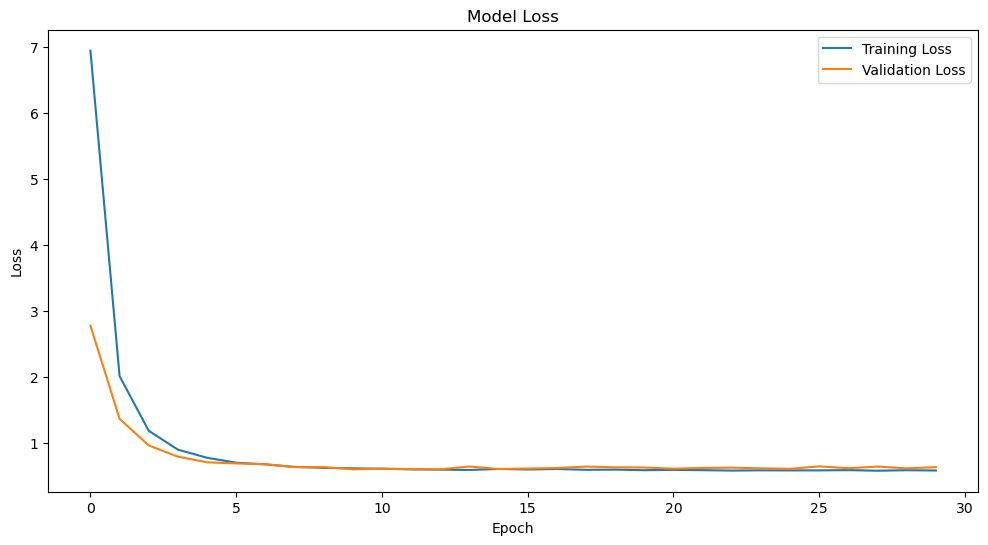

In [34]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# # Plot training & validation MAE values
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['mae'], label='Training MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')
# plt.title('Model MAE')
# plt.ylabel('MAE')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.show()


In [35]:
Y_test

array([[14.50512274,  1.16921739,  0.56211705,  1.69066667,  2.544     ],
       [15.7802536 ,  0.31579866,  1.14641698,  1.52514286,  2.22133333],
       [13.28466097,  0.44550637,  0.35398488,  1.772     ,  2.86      ],
       ...,
       [13.54298007,  0.73717232,  0.36146898,  1.98733333,  2.3768    ],
       [11.73131576,  0.46166573,  0.73436265,  1.958     ,  3.14      ],
       [14.72677045,  1.42251539,  0.70184494,  1.738     ,  2.3664    ]])

In [36]:
Y_pred

[array([[18.116262],
        [17.906853],
        [17.73138 ],
        ...,
        [15.560395],
        [15.545187],
        [15.520543]], dtype=float32),
 array([[0.50960976],
        [0.49459845],
        [0.4461929 ],
        ...,
        [0.4844605 ],
        [0.52143794],
        [0.60068923]], dtype=float32),
 array([[0.5579043 ],
        [0.5510711 ],
        [0.50762314],
        ...,
        [0.5289374 ],
        [0.56298566],
        [0.6353902 ]], dtype=float32),
 array([[1.3221452],
        [1.3228897],
        [1.3239003],
        ...,
        [1.4650179],
        [1.4551605],
        [1.5100027]], dtype=float32),
 array([[1.8676794],
        [1.9004455],
        [1.9367062],
        ...,
        [2.219776 ],
        [2.2067125],
        [2.2531815]], dtype=float32)]

Output 0: Pearson Correlation: 0.16405149416999723
Output 0: P-value: 1.4903559224920203e-11
Output 1: Pearson Correlation: 0.4466229753244195
Output 1: P-value: 9.097083905187433e-83
Output 2: Pearson Correlation: 0.37314263426137295
Output 2: P-value: 2.215706059344008e-56
Output 3: Pearson Correlation: 0.12334682158786944
Output 3: P-value: 4.209708903193577e-07
Output 4: Pearson Correlation: 0.010948174640159677
Output 4: P-value: 0.6546219907040017


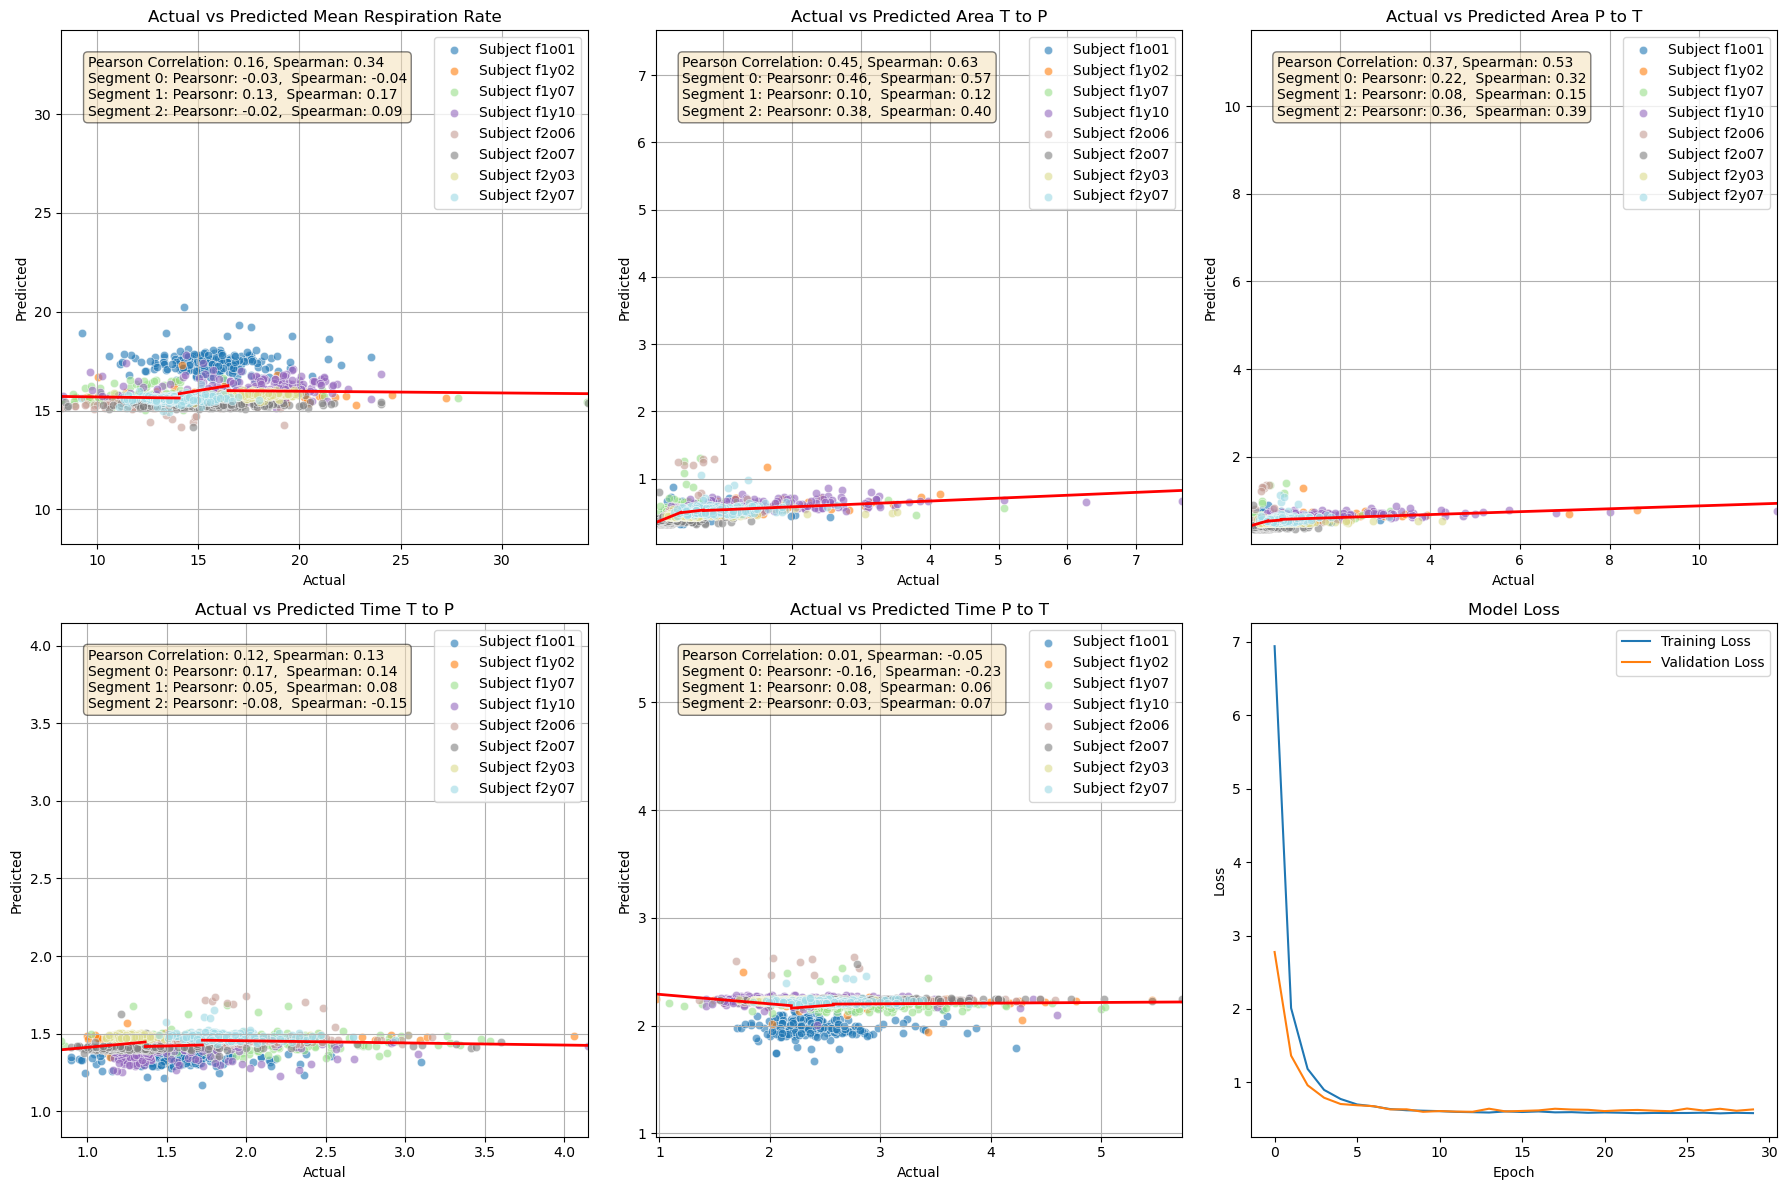

In [37]:
# Function to fit and plot piecewise linear regression
def piecewise_regression(x, y, breakpoints, ax):
    segments = np.split(np.argsort(x), np.searchsorted(x[np.argsort(x)], breakpoints))
    segment_texts = []
    
    for i,segment in enumerate(segments):
        if len(segment) > 1:  # Fit line if segment contains more than one point
            slope, intercept, _, _, _ = linregress(x[segment], y[segment])
            ax.plot(x[segment], slope * x[segment] + intercept, color='red', linewidth=2)
            
            # Calculate Pearson correlation coefficient and p-value for each segment
            corr, p_val = pearsonr(x[segment], y[segment])
            spearman_corr, spearman_p_val = spearmanr(x[segment], y[segment])
            segment_texts.append(f'Segment {i}: Pearsonr: {corr:.2f},  Spearman: {spearman_corr:.2f}')
    
    return segment_texts
# Get a list of unique subject IDs and create a color map
unique_subject_ids = np.unique(test_subject_id)
colors = plt.colormaps['tab20'](np.linspace(0, 1, len(unique_subject_ids)))
color_map = {subject_id: colors[i] for i, subject_id in enumerate(unique_subject_ids)}

# Initialize the figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
output_names = ['Mean Respiration Rate', 'Area T to P', 'Area P to T', 'Time T to P', 'Time P to T']

for i in range(5):
    # Calculate the Pearson correlation coefficient
    correlation, p_value = pearsonr(Y_test[:, i], Y_pred[i].flatten())
    spearman_corr, spearman_p_value = spearmanr(Y_test[:, i], Y_pred[i].flatten())
    print(f"Output {i}: Pearson Correlation: {correlation}")
    print(f"Output {i}: P-value: {p_value}")

    # # Create scatter plot
    # axes[i].scatter(Y_test[:, i], Y_pred[i].flatten(), alpha=0.6, edgecolors='w', linewidth=0.5, label='Data points')
    
    for subject_id in unique_subject_ids:
        mask = test_subject_id == subject_id
        axes[i].scatter(Y_test[mask, i], Y_pred[i].flatten()[mask], alpha=0.6, edgecolors='w', linewidth=0.5, label=f'Subject {subject_id}', color=color_map[subject_id])
    # Define breakpoints
    breakpoints = np.percentile(Y_test[:, i], [33, 66])

    # Fit and plot piecewise regression
    segment_texts = piecewise_regression(Y_test[:, i], Y_pred[i].flatten(), breakpoints, axes[i])

    axes[i].set_title(f'Actual vs Predicted {output_names[i]}')
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

    # Add text box with correlation and p-value
    textstr = f'Pearson Correlation: {correlation:.2f}, Spearman: {spearman_corr:.2f}\n' + '\n'.join(segment_texts)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=10,
                 verticalalignment='top', bbox=props)

# Plot the model loss
axes[5].plot(history.history['loss'], label='Training Loss')
axes[5].plot(history.history['val_loss'], label='Validation Loss')
axes[5].set_title('Model Loss')
axes[5].set_ylabel('Loss')
axes[5].set_xlabel('Epoch')
axes[5].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Ensure x and y axes have the same scale
for i, ax in enumerate(axes):
    if i < len(output_names):
        ax.set_xlim([min(Y_test[:, i].min(), Y_pred[i].min()), max(Y_test[:, i].max(), Y_pred[i].max())])
        ax.set_ylim([min(Y_test[:, i].min(), Y_pred[i].min()), max(Y_test[:, i].max(), Y_pred[i].max())])

plt.show()

In [38]:
np.unique(test_subject_id)

array(['f1o01', 'f1y02', 'f1y07', 'f1y10', 'f2o06', 'f2o07', 'f2y03',
       'f2y07'], dtype=object)

In [39]:
# list_id = ['f2y08']
# list_id = np.unique(test_subject_id)
# num_examples_to_plot = 10

# for current_subject_id in np.unique(test_subject_id):
    
#     # Shuffle and select a few examples from the test set
#     mask = (test_subject_id == current_subject_id)
#     Y_pred_filtered_rr = Y_pred[0][mask].flatten() 
#     Y_pred_filtered_area_T_to_P = Y_pred[1][mask].flatten()
#     Y_pred_filtered_area_P_to_T = Y_pred[2][mask].flatten()
#     Y_pred_filtered_time_T_to_P = Y_pred[3][mask].flatten()
#     Y_pred_filtered_time_P_to_T = Y_pred[4][mask].flatten()
    
#     Y_true_filtered_rr = Y_test[mask][:,0]
#     Y_true_filtered_area_T_to_P = Y_test[mask][:,1]
#     Y_true_filtered_area_P_to_T = Y_test[mask][:,2]
#     Y_true_filtered_time_T_to_P = Y_test[mask][:,3]
#     Y_true_filtered_time_P_to_T = Y_test[mask][:,4]
    
#     X_test_filtered = X_test[mask]
    
    
    
#     #Plot the selected examples from the test set
#     fig, axes = plt.subplots(num_examples_to_plot, 1, figsize=(12, 3*num_examples_to_plot))
#     for i, ax in enumerate(axes):
#         idx = random.randint(0, len(X_test_filtered)-1)
#         print(idx)
#         # Plot the sample
#         ax.plot(X_test_filtered[idx].flatten())
#         ax.set_title(f'Subject ID: {current_subject_id}. Test Sample: {idx}')
    
#         #Adding text box for comparison
#         textstr = '\n'.join((
#             f'             [Respiration Rate, Area Trough to Peak, Area Peak to Trough, Time Trough to Peak, Time Peak to Trough]', 
#             f'Predict: [{Y_pred_filtered_rr[idx]:.2f},  {Y_pred_filtered_area_T_to_P[idx]:22.2f},  {Y_pred_filtered_area_P_to_T[idx]:27.2f},  {Y_pred_filtered_time_T_to_P[idx]:27.2f},  {Y_pred_filtered_time_P_to_T[idx]:27.2f}]',
#             f'True:     [{Y_true_filtered_rr[idx]:.2f},  {Y_true_filtered_area_T_to_P[idx]:22.2f},  {Y_true_filtered_area_P_to_T[idx]:27.2f},  {Y_true_filtered_time_T_to_P[idx]:27.2f},  {Y_true_filtered_time_P_to_T[idx]:27.2f}]',
#         ))
#         ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
#                 verticalalignment='top', bbox=dict(facecolor='yellow', alpha=0.8))
    
#     plt.tight_layout()
    
#     SAVE_DIR = OUTPUT_DIR + 'sample/'
#     if(not(os.path.exists(SAVE_DIR))):
#         os.makedirs(SAVE_DIR)
#     plt.savefig(SAVE_DIR + f'sample_{current_subject_id}.png')
#     #plt.show()
#     plt.close()

# Grid Search

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt

def piecewise_regression(x, y, breakpoints, ax):
    segments = np.split(np.argsort(x), np.searchsorted(x[np.argsort(x)], breakpoints))
    segment_texts = []
    
    for i,segment in enumerate(segments):
        if len(segment) > 1:  # Fit line if segment contains more than one point
            slope, intercept, _, _, _ = linregress(x[segment], y[segment])
            ax.plot(x[segment], slope * x[segment] + intercept, color='red', linewidth=2)
            
            # Calculate Pearson correlation coefficient and p-value for each segment
            corr, p_val = pearsonr(x[segment], y[segment])
            spearman_corr, spearman_p_val = spearmanr(x[segment], y[segment])
            segment_texts.append(f'Segment {i}: Pearsonr: {corr:.2f},  Spearman: {spearman_corr:.2f}')
    
    return segment_texts
    
if(not(os.path.exists(OUTPUT_DIR))):
    os.makedirs(OUTPUT_DIR)
    
# Define the grid search parameters
param_grid = {
    'start_neuron': [32],
    'kernel_size': [9],
    'strides_size': [3],
    'max_pool_size': [5],
    'dropout': [0.3],
    'padding' :['same'],
    'batch_size' : [64],
    'huber_delta' : [0.75],
}

# Prepare callbacks


# Number of epochs
EPOCHS = 200
PATIENCE = 20

# Initialize a list to store the loss history for all configurations
loss_history = []

# Perform grid search
for start_neuron in param_grid['start_neuron']:
    for kernel_size in param_grid['kernel_size']:
        for strides_size in param_grid['strides_size']:
            for max_pool_size in param_grid['max_pool_size']:
                for dropout in param_grid['dropout']:
                    for padding in param_grid['padding']:
                        for batch_size in param_grid['batch_size']:
                            for delta in param_grid['huber_delta']:
                                print(f'start_neuron={start_neuron}, kernel_size={kernel_size}, strides_size={strides_size}, max_pool_size={max_pool_size}, dropout={dropout}, padding={padding}, batch_size={batch_size}, huber_delta={delta}')
                                
                                reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=PATIENCE//2,verbose=1, min_delta=0.00001,)
                                early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights = True, mode = 'min')
                                # Create the model
                                model = create_3_input_model_5_output((X_train.shape + X_train_wavelet.shape + X_train_feature.shape), start_neuron=start_neuron, kernel_size=kernel_size,
                                                                  strides_size=strides_size, max_pool_size=max_pool_size, 
                                                                  dropout=dropout, padding=padding, delta=delta)
                                #model.summary()
    
    
                                # Train the model
                                history = model.fit([X_train,X_train_wavelet,X_train_feature], [Y_train[:,0],Y_train[:,1],Y_train[:,2],Y_train[:,3],Y_train[:,4]], 
                                                    validation_data=([X_val,X_val_wavelet,X_val_feature], [Y_val[:,0],Y_val[:,1],Y_val[:,2],Y_val[:,3],Y_val[:,4]]), 
                                                    epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1, shuffle=True, 
                                                    callbacks=[early_stopping, reduce_lr])



                                min_train_loss = min(history.history['loss'])
                                min_val_lost = min(history.history['val_loss'])
                                # Save loss history for the current configuration
                                config_loss_history = {
                                    'config': f'start_neuron={start_neuron}, kernel_size={kernel_size}, strides_size={strides_size}, max_pool_size={max_pool_size}, dropout={dropout}, padding={padding}, batch_size={batch_size}, huber_delta={delta}',
                                    'training_loss': history.history['loss'],
                                    'validation_loss': history.history['val_loss'],
                                    'min' : f'Best_train_loss{min_train_loss}, best_val_loss{min_val_lost}'
                                }
                                loss_history.append(config_loss_history)
    
                                # Evaluate the model
                                Y_pred = model.predict([X_test,X_test_wavelet,X_test_feature],verbose=0)

                                plt.clf()
                                unique_subject_ids = np.unique(test_subject_id)
                                colors = plt.colormaps['tab20'](np.linspace(0, 1, len(unique_subject_ids)))
                                color_map = {subject_id: colors[i] for i, subject_id in enumerate(unique_subject_ids)}


                                # Initialize the figure and subplots
                                # Create plots
                                fig, axes = plt.subplots(2, 3, figsize=(18, 12))
                                axes = axes.flatten()
                                output_names = ['Mean Respiration Rate', 'Area T to P', 'Area P to T', 'Time T to P', 'Time P to T']
    
                                for i in range(5):
                                    # Calculate the Pearson correlation coefficient
                                    correlation, p_value = pearsonr(Y_test[:, i], Y_pred[i].flatten())
                                    print(f"Output {i}: Pearson Correlation: {correlation}")
                                    print(f"Output {i}: P-value: {p_value}")
                                
                                    # # Create scatter plot
                                    # axes[i].scatter(Y_test[:, i], Y_pred[i].flatten(), alpha=0.6, edgecolors='w', linewidth=0.5, label='Data points')
                                    
                                    for subject_id in unique_subject_ids:
                                        mask = test_subject_id == subject_id
                                        axes[i].scatter(Y_test[mask, i], Y_pred[i].flatten()[mask], alpha=0.6, edgecolors='w', linewidth=0.5, label=f'Subject {subject_id}', color=color_map[subject_id])
                                
                                    # Define breakpoints
                                    breakpoints = np.percentile(Y_test[:, i], [33, 66])
                                
                                    # Fit and plot piecewise regression
                                    segment_texts = piecewise_regression(Y_test[:, i], Y_pred[i].flatten(), breakpoints, axes[i])
                                
                                    axes[i].set_title(f'Actual vs Predicted {output_names[i]}')
                                    axes[i].set_xlabel('Actual')
                                    axes[i].set_ylabel('Predicted')
                                    axes[i].grid(True)
                                    axes[i].legend()
                                
                                    # Add text box with correlation and p-value
                                    textstr = f'Pearson Correlation: {correlation:.2f}\n' + '\n'.join(segment_texts)
                                    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                                    axes[i].text(0.05, 0.95, textstr, transform=axes[i].transAxes, fontsize=10,
                                                 verticalalignment='top', bbox=props)
                                
                                # Plot the model loss
                                axes[5].plot(history.history['loss'], label='Training Loss')
                                axes[5].plot(history.history['val_loss'], label='Validation Loss')
                                axes[5].set_title('Model Loss')
                                axes[5].set_ylabel('Loss')
                                axes[5].set_xlabel('Epoch')
                                axes[5].legend(loc='upper right')

                                # Adjust layout to prevent overlap
                                plt.tight_layout()
                                
                                # Ensure x and y axes have the same scale
                                for i, ax in enumerate(axes):
                                    if i < len(output_names):
                                        ax.set_xlim([min(Y_test[:,i].min(), Y_pred[i].min()), max(Y_test[:,i].max(), Y_pred[i].max())])
                                        ax.set_ylim([min(Y_test[:,i].min(), Y_pred[i].min()), max(Y_test[:,i].max(), Y_pred[i].max())])
    
                                # Save the plot
                                plt.savefig(OUTPUT_DIR + f'grid_search_{start_neuron}_{kernel_size}_{strides_size}_{max_pool_size}_{dropout}_{padding}_{batch_size}_{delta}.png')
                                plt.close()

# Save loss history to a text file
with open(OUTPUT_DIR + 'loss_history.txt', 'w') as f:
    for entry in loss_history:
        f.write(f"Configuration: {entry['config']}\n")
        f.write(f"Training Loss: {entry['training_loss']}\n")
        f.write(f"Validation Loss: {entry['validation_loss']}\n")
        f.write(f"{entry['min']}\n")
        f.write("\n")

print("Grid search completed and results saved.")

start_neuron=32, kernel_size=9, strides_size=3, max_pool_size=5, dropout=0.3, padding=same, batch_size=64, huber_delta=0.75
Epoch 1/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 8.6957 - val_loss: 0.9403 - learning_rate: 0.0010
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.9185 - val_loss: 0.7397 - learning_rate: 0.0010
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.7028 - val_loss: 0.6669 - learning_rate: 0.0010
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.6630 - val_loss: 0.7245 - learning_rate: 0.0010
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.6317 - val_loss: 0.6191 - learning_rate: 0.0010
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.6239 - val_loss: 0.6456 - learning_rate: 0.0010
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.5991 - val_loss: 0.6650 - learning_rate: 0.0010
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.5822 - val_loss: 0.6594 - learning_rate: 0.

<Figure size 640x480 with 0 Axes>

In [41]:
# param_grid = {
#     'start_neuron': [32,64],
#     'kernel_size': [5,7,9,11],
#     'strides_size': [1,2,3,4],
#     'max_pool_size': [2,3],
#     'dropout': [0.3,0.4,0.5],
#     'padding' :['same','valid'],
#     'batch_size' : [64],
#     'huber_delta' : [0.5,1],
    
# }